# Mission field analysis

We start the analisys of the enriched GTR dataset (see `01` and `02` notebooks)

## Mission field analysis

### Descriptive statistics

#### Mission field basics

A mission field represents the combination of keywords (subjects/verbs/objects) that comprise a mission. 

For example, the potential mission field $MF_p$ for `using AI (AI) to prevent, diagnose and treat chronic diseases (C)` is formed by $AI \cup C$. 

This captures the total of technological activity $AI$ that could be devoted to adressing the challenge $C$.

The active mission field $MF_a$ is $AI \cap C$, capturing the actual number of projects that combine the activities.

Some hypotheses:

* $\frac{MF_a}{MF_p} < \frac{A}{Total}$
* $\frac{MF_a}{MF_p} < \frac{C}{Total}$

This means that the challenge is underrepresented among the applications of the technology, and that the technology is underrepresented among the attempted solutions to the challenge.

Note that the above is sort of assuming that the solution field and the challenge field are far apart in the knowledge space. We could test this if we mapped that, but it would require us to classify all projects into their topics. We can sort of proxy this for now by analyzing the organizational network in the three domains. 

The solution seems underrepresented in the challenge compared to the total of projects

The challenge seems underrepresented in the solution compared to the total of projects

#### Trends

We assume growth in the effective mission field but potentially slower than either of its components (there is some sort of barrier preventing the application of the solution to the challenge).

$\frac{\delta MF_a}{\delta t} < \frac{\delta A}{\delta t}$

$\frac{\delta MF_a}{\delta t} < \frac{\delta C}{\delta t}$

#### Funding

The funder for the mission fied might be different from the funder for the constituent parts. I would expect the mission funder to be related (closer) to the challenge.

#### Discipline mix

The effective mission field will contain a higher level of discipline diversity than the constituent parts (although here we need to remember that the constituent parts might also be related to other missions we are not capturing).

## Preamble

In [1]:
%matplotlib inline

from scipy.stats import entropy

import matplotlib.pyplot as plt

plt.rc('font', family = 'serif',serif='Times New Roman') 

## Load data

In [2]:
projects = pd.read_csv('../data/processed/22_1_2019_projects_clean.csv')

### Word embeddings query / Clio query?

To keep things simple, we will train a w2v model, identify synonyms for a set of seed terms and query the data for those

In [3]:
# %load lda_pipeline.py
from gensim import corpora, models
from string import punctuation
from string import digits
import re
import pandas as pd
import numpy as np
from gensim.models import Word2Vec


#Characters to drop
drop_characters = re.sub('-','',punctuation)+digits

#Stopwords
from nltk.corpus import stopwords

stop = stopwords.words('English')

#Stem functions
from nltk.stem import *
stemmer = PorterStemmer()

def flatten_list(a_list):
    return([x for el in a_list for x in el])


def clean_tokenise(string,drop_characters=drop_characters,stopwords=stop):
    '''
    Takes a string and cleans (makes lowercase and removes stopwords)
    
    '''
    

    #Lowercase
    str_low = string.lower()
    
    
    #Remove symbols and numbers
    str_letters = re.sub('[{drop}]'.format(drop=drop_characters),'',str_low)
    
    
    #Remove stopwords
    clean = [x for x in str_letters.split(' ') if (x not in stop) & (x!='')]
    
    return(clean)


class CleanTokenize():
    '''
    This class takes a list of strings and returns a tokenised, clean list of token lists ready
    to be processed with the LdaPipeline
    
    It has a clean method to remove symbols and stopwords
    
    It has a bigram method to detect collocated words
    
    It has a stem method to stem words
    
    '''
    
    def __init__(self,corpus):
        '''
        Takes a corpus (list where each element is a string)
        '''
        
        #Store
        self.corpus = corpus
        
    def clean(self,drop=drop_characters,stopwords=stop):
        '''
        Removes strings and stopwords, 
        
        '''
        
        cleaned = [clean_tokenise(doc,drop_characters=drop,stopwords=stop) for doc in self.corpus]
        
        self.tokenised = cleaned
        return(self)
    
    def stem(self):
        '''
        Optional: stems words
        
        '''
        #Stems each word in each tokenised sentence
        stemmed = [[stemmer.stem(word) for word in sentence] for sentence in self.tokenised]
    
        self.tokenised = stemmed
        return(self)
        
    
    def bigram(self,threshold=10):
        '''
        Optional Create bigrams.
        
        '''
        
        #Colocation detector trained on the data
        phrases = models.Phrases(self.tokenised,threshold=threshold)
        
        bigram = models.phrases.Phraser(phrases)
        
        self.tokenised = bigram[self.tokenised]
        
        return(self)
        
        
        
        

class LdaPipeline():
    '''
    This class processes lists of keywords.
    How does it work?
    -It is initialised with a list where every element is a collection of keywords
    -It has a method to filter keywords removing those that appear less than a set number of times
    
    -It has a method to process the filtered df into an object that gensim can work with
    -It has a method to train the LDA model with the right parameters
    -It has a method to predict the topics in a corpus
    
    '''
    
    def __init__(self,corpus):
        '''
        Takes the list of terms
        '''
        
        #Store the corpus
        self.tokenised = corpus
        
    def filter(self,minimum=5):
        '''
        Removes keywords that appear less than 5 times.
        
        '''
        
        #Load
        tokenised = self.tokenised
        
        #Count tokens
        token_counts = pd.Series([x for el in tokenised for x in el]).value_counts()
        
        #Tokens to keep
        keep = token_counts.index[token_counts>minimum]
        
        #Filter
        tokenised_filtered = [[x for x in el if x in keep] for el in tokenised]
        
        #Store
        self.tokenised = tokenised_filtered
        self.empty_groups = np.sum([len(x)==0 for x in tokenised_filtered])
        
        return(self)
    
    def clean(self):
        '''
        Remove symbols and numbers
        
        '''
        
        
        
    
        
    def process(self):
        '''
        This creates the bag of words we use in the gensim analysis
        
        '''
        #Load the list of keywords
        tokenised = self.tokenised
        
        #Create the dictionary
        dictionary = corpora.Dictionary(tokenised)
        
        #Create the Bag of words. This converts keywords into ids
        corpus = [dictionary.doc2bow(x) for x in tokenised]
        
        self.corpus = corpus
        self.dictionary = dictionary
        return(self)
        
    def tfidf(self):
        '''
        This is optional: We extract the term-frequency inverse document frequency of the words in
        the corpus. The idea is to identify those keywords that are more salient in a document by normalising over
        their frequency in the whole corpus
        
        '''
        #Load the corpus
        corpus = self.corpus
        
        #Fit a TFIDF model on the data
        tfidf = models.TfidfModel(corpus)
        
        #Transform the corpus and save it
        self.corpus = tfidf[corpus]
        
        return(self)
    
    def fit_lda(self,num_topics=20,passes=5,iterations=75,random_state=1803):
        '''
        
        This fits the LDA model taking a set of keyword arguments.
        #Number of passes, iterations and random state for reproducibility. We will have to consider
        reproducibility eventually.
        
        '''
        
        #Load the corpus
        corpus = self.corpus
        
        #Train the LDA model with the parameters we supplied
        lda = models.LdaModel(corpus,id2word=self.dictionary,
                              num_topics=num_topics,passes=passes,iterations=iterations,random_state=random_state)
        
        #Save the outputs
        self.lda_model = lda
        self.lda_topics = lda.show_topics(num_topics=num_topics)
        

        return(self)
    
    def predict_topics(self):
        '''
        This predicts the topic mix for every observation in the corpus
        
        '''
        #Load the attributes we will be working with
        lda = self.lda_model
        corpus = self.corpus
        
        #Now we create a df
        predicted = lda[corpus]
        
        #Convert this into a dataframe
        predicted_df = pd.concat([pd.DataFrame({x[0]:x[1] for x in topics},
                                              index=[num]) for num,topics in enumerate(predicted)]).fillna(0)
        
        self.predicted_df = predicted_df
        
        return(self)
    

In [4]:
#Create sentence corpus
sentence_corpus = flatten_list([x.split('. ') for x in projects['abstract']])


#Tokenize etc using the classes above
sentence_tokenised = CleanTokenize(sentence_corpus).clean().bigram()

#Also tokenise by documents so we can query them later
corpus_tokenised = CleanTokenize(projects['abstract']).clean().bigram()


In [5]:
#Training W2V
w2v = Word2Vec(sentence_tokenised.tokenised)

In [6]:
with open(f'../models/{today_str}_word_embeddings.p','wb') as outfile:
    pickle.dump(w2v,outfile)

In [7]:
def similarity_chaser(seed_list,model,similarity,occurrences=1):
    '''
    Takes a seed term and expands it with synonyms (above a certain similarity threshold)
    
    '''
    
    #All synonyms of the terms in the seed_list above a certain threshold
    set_ws = flatten_list([[term[0] for term in model.most_similar(seed) if term[1]>similarity] for seed in seed_list])
    
    #return(set_ws)
    
    #This is the list of unique occurrences (what we want to return at the end)
    set_ws_list = list(set(set_ws))
    
    #For each term, if it appears multiple times, we expand
    for w in set_ws:
        if set_ws.count(w)>occurrences:
            
            #As before
            extra_words = [term[0] for term in model.wv.most_similar(w) if term[1]>similarity]
            
            set_ws_list + extra_words
            
    #return(list(set(set_ws_list)))
    #return(set_ws_list)
    return(set_ws)

    
def querier(corpus,keywords):
    '''
    Loops over a tokenised corpus and returns varios measures indicating the presence of keywords in it.
    
    This includes:
    
    * Whether at least one keyword appears
    * How many keywords appear
    * What keywords appear
    
    
    '''
    #Empty dict with keywords
    #kw_dict = {k:[] for k in keywords}
    
    #Loop through the corpus and create a vectorised df of the keywords
    
    out = pd.concat([pd.Series({x:(doc.count(x)) for x in keywords}) for doc in corpus],axis=1).T
    
    
    #print(kw_dict)
    #Note that this also returns a sum of the keywords over the rows and a 
    return([out, out.sum(axis=1)])
    

#     #Intersection of tokens
#     if intersect==True:
    
#         out = [len(set(keywords) & set(document)) for document in corpus]
    
#     else:
#     #Otherwise it counts the total of tokens present in an abstract
        
#         out = [np.sum([x.count(k) for k in keywords]) for x in corpus]
    
    
    
    
    return(out)
    
    

### AI and Chronic diseases (crude keyword search-based)

In [8]:
#These are prototype words. 
ai_seed = ['machine_learning','artificial_intelligence','deep_learning','ai','machine_vision','text_mining','data_mining']
chronic_seed = ['chronic_disease','chronic_condition','addiction','alzheimers','atrial_fibrillation','autoimmune_disease',
               'lupus','bipolar_disorder','blindness','cerebral_palsy','chronic_hepatitis','depression','chronic_pain',
               'deafness','blindness','endometriosis','epilepsy','hiv','aids','huntingtons','hypertension','lyme',
               'sclerosis','parkinsons','sickle_cell','cancer','cardiovascular_disease','diabetes']

#Discipline terms
discs = ['biological_sciences', 
         #'physics', 
         'engineering_technology',
       'medical_sciences', 'social_sciences', 'mathematics_computing',
       'environmental_sciences', 'arts_humanities']

#Impact terms
imps = ['prods', 'ip', 'tech', 'spin', 'pubs']



In [9]:
def random_check(corpus,num,length):
    '''
    Prints num random examples form corpus
    
    '''
    
    selected = np.random.randint(0,len(corpus),num)
    
    texts  = [text for num,text in enumerate(corpus) if num in selected]
    
    for t in texts:
        print(t[:length])
        print('====')

In [10]:
class missionKeywords():
    '''
    
    input: a list of projects with descriptions, dates, funding and outputs.
    
    -Expands keywords in a model (this could be clio or something else
    '''
    
    def __init__(self,projects,corpus_tokenised,model):
        '''
        
        Initialises the class with the projects and the w2v model we will use.
        
        '''
        
        self.projects = projects

        #This is the project df but with text description tokenised. We query it with the keywords 
        
        self.tokenised = corpus_tokenised
        self.w2v = model
        
        
    def keyword_expansion(self,mission_dict,thres):
        '''
        
        Expands a seed list of keywords. We input those as a dict where key corresponds to the type of input (solution or
        challenge, say) and the values are a list with the name of the entity (eg 'AI') and the seedlist to expand
        
        '''
        
        #Store the names eg 'challenge_chronic'
        self.names = [v[0] for k,v in mission_dict.items()]
        
        #Store the keywords
        self.keywords = [v[1] for k,v in mission_dict.items()]
        
        #Expand the keywords
        self.expanded_keywords = [list(set(kw + similarity_chaser(seed_list=kw,model=self.w2v,similarity=thres))) for
                                 kw in self.keywords]
        
        return(self)
        
    

In [11]:
class missionClassifier(missionKeywords):
    '''
    Classifies projects based on their keywords
    
    '''
    
    def __init__(self,missionKeywords):
        '''
        Initialise
        
        '''
        
        self.projects_labelled = missionKeywords.projects.copy()
        self.tokenised = missionKeywords.tokenised
        self.names = missionKeywords.names
        self.expanded_keywords = missionKeywords.expanded_keywords
    
    
    def filter_keywords(self,kws_to_drop):
        '''
        We can use it to drop irrelevant keywords. We 
        
        '''
                      
        #self.projects_labelled = self.projects_labelled[[x for x in self.projects_labelled.columns if x not in kws_to_drop]]
        
        self.expanded_keywords = [[x for x in kwset if x not in kws_to_drop] for kwset in self.expanded_keywords]
        
        
        return(self)
   
    
        
    
    def query_data(self,verbose=True):
        '''
        Queries the data with the keywords. It stores two attributes: the kw counts contain the counts by keywords 
        and challenge name; it also stores the projects labelled with an extra variable that
        counts the number of times that keywords in either set of keywords appears in the data.
        
        '''
        
        self.kw_counts = {}
        
        projects_labelled = self.projects_labelled
        tokenised = self.tokenised
        
        #We look for projects with keywords. Loop over name and extract the right index from the expanded keyword set.
        #This could also work as a dict.
        
        for num,name in enumerate(self.names):
            
            if verbose==True:
                print(name)
            
            outputs = querier(tokenised,self.expanded_keywords[num])
            
            self.kw_counts[name] = outputs[0]
            
            projects_labelled[name] = outputs[1]
            
        self.projects_labelled = projects_labelled
        
        return(self)
        
        
        
    

In [12]:
class missionProfiler(missionClassifier):
    '''
    Takes as input an instance of the class missionClassifier

    -Generates some descriptive statistics about the projects
    -Generates some graphs about the projects.
    
    '''
    
    def __init__(self,missionClassifier):
        '''
        
        Initialise
        '''
        
        self.projects_labelled = missionClassifier.projects_labelled.copy()
        self.names = missionClassifier.names.copy()
        self.expanded_keywords = missionClassifier.expanded_keywords.copy()
        
        self.column_names = [self.names[0]+'_and_'+self.names[1],self.names[0],self.names[1]]
    
    
    def mission_examples(self,n,length,text_var='abstract',thr=0):
        '''
        Prints n examples of missions using the text variable that was specified
        
        '''
        
        names = self.names
        
        for name in names:
            print(name)
            print('\n')
            
            random_check(corpus=list(self.projects_labelled.loc[self.projects_labelled[name]>thr,text_var]),
                         num=n,
                         length=200)
            
            print('\n')
        
        print(names[0]+' and ' + names[1])
        print('\n')
        random_check(corpus=list(self.projects_labelled.loc[
            (self.projects_labelled[names[0]]>thr) & (self.projects_labelled[names[1]]>thr),text_var]),
                         num=n,
                         length=length)
            
        
        
    def mission_field_basics(self,field_filter=[0,0],verbose=True):
        '''
        Generates estimates of activity in a field. field_filter refers to whether
        '''
        
        projects = self.projects_labelled
        names = self.names
        
        #Do the filter. Note that we assume that the user here will have done some EDA of the results to choose the right
        #filter.
        
        #Binarise. Note that the default assumes that the values here are a 
        for num,n in enumerate(names):
            projects[n] = projects[n].apply(lambda x: 1 if x> field_filter[num] else 0)
            
        
        
        #What's the size of the potential and effective mission field?
        #TODO: generalise to more than two fields.
        
        #Potential mission field
        union = projects.loc[(projects[names[0]]==True)|(projects[names[1]]==True),:]

        #Active mission field
        intersection = projects.loc[(projects[names[0]]==True)& (projects[names[1]]==True),:]

        #field 0 totals
        field_0 = projects.loc[(projects[names[0]]==True),:]

        #Fields 1 totals
        field_1 = projects.loc[(projects[names[1]]==True),:]
        
        #We are not very interested in the union of fields
        self.sets = [intersection,field_0,field_1]

        summary = {names[0]+'_or_'+names[1]:len(union),
                   names[0]+'_and_'+names[1]:len(intersection),
                   names[0]+'_total':len(field_0),
                   names[1]+'_total':len(field_1)}
        
        if verbose==True:
            print(summary)
        
        #Store the mission summary
        self.mission_summary = summary
        
               
        #Mission basics (over / underrepresentation of )
        mission_basics = pd.Series([100*len(intersection)/len(field_0),100*len(field_1)/len(projects),
                                    100*len(intersection)/len(field_1),100*len(field_0)/len(projects)],
               index=[names[0]+'_and_'+names[1]+'as_share_of_'+names[0],
                      names[1]+'_as_share_of all',
                      names[0]+'_and_'+names[1]+'_as_share_of'+names[1],
                      names[0]+'_as_share_of all'])
        
        self.mission_basics = mission_basics
        
        return(self)
        
    def mission_trends(self,years=[2006,2019],funding=False,year_var='year'):
        '''
        Calculates mission trends over time.
        
        '''
        
        #Extract projects
        projects =self.projects_labelled
        
        names = self.names
        
        #Results dict
        
        self.trends = {}
        
        
        #####
        #Year trends
        #####
        
        #Year counts for each variable of interest
        trends = pd.concat([df[year_var].value_counts(normalize=1) for df in self.sets],axis=1)
        
        trends.columns =self.column_names
        
        project_trends = trends.loc[(trends.index>years[0]) & (trends.index<years[1])]
        
        self.trends['project_trends'] = project_trends
        
        
        #And also look at funding (if available)
        if funding!=False:
            
            #This calculates totals of funding and normalises over the interval to see if recent periods have more activity
            
            funding_trends = pd.concat([df.groupby(year_var)[funding].sum() for df in self.sets],axis=1)
            
            funding_trends.columns = self.column_names
            
            funding_norm = funding_trends.apply(lambda x: x/x.sum(),axis=0)
            
            funding_norm = funding_norm.loc[(funding_norm.index>years[0]) & (funding_norm.index<years[1])]

            self.trends['funding_trends'] = funding_norm
    
        
        ####
        #Yearly shares
        ####
        
        #Normalises for each period. NB there is a loooot of repetition below. Need to refactor.
        
        trends_as_share = pd.concat([df.year.value_counts() for df in self.sets],axis=1)

        trends_as_share.columns = self.column_names

        #This gets the number of projects in the mission as a share of the total
        trends_as_share[
            f'mission_field_share_{names[0]}'],trends_as_share[f'mission_field_share_{names[1]}'] = [
            trends_as_share.iloc[:,0]/trends_as_share.iloc[:,num] for num in [1,2]]
        
        trends_as_share = trends_as_share.loc[(trends_as_share.index>years[0]) & (trends_as_share.index<years[1])]
        
        self.trends['project_shares'] = trends_as_share
        
        #And also funding (if available)
        
        if funding != False:
            
            #We use the funding trend df from above
            funding_as_share = funding_trends.copy()
            
            funding_as_share[
                f'mission_field_share_{names[0]}'],funding_as_share[f'mission_field_share_{names[1]}'] = [
                funding_as_share.iloc[:,0]/funding_as_share.iloc[:,num] for num in [1,2]]
            
            funding_as_share = funding_as_share.loc[(funding_as_share.index>years[0]) & (funding_as_share.index<years[1])]
            
            self.trends['funding_shares'] = funding_as_share
            
        return(self)
            
            
    def funder_trends(self,years=[2006,2019],funder_var='funder',year_var='year',funding=False):
        '''
        Funding plots
        
        '''
        
        
        self.funders = {}
        
        names = self.names
        
        #####
        #Funding totals
        ####
        
        #As before... this gets funder shares of activity
        funders = pd.concat([df[funder_var].value_counts(normalize=1) for df in self.sets],axis=1)

        funders.columns = self.column_names
        
        self.funders['funder_projects'] = funders
        
        #If we want to look at funding
        
        if funding != False:
            funding_shares = pd.concat([df.groupby(funder_var)[funding].sum() for df in self.sets],axis=1)
            
            funding_shares = funding_shares.apply(lambda x: x/x.sum(),axis=0)
            
            funding_shares.columns = self.column_names
        
            self.funders['funder_funding'] = funding_shares

        ######
        #Funding trends
        ######
        
        mission_field = self.sets[0]
        
        self.funders['funder_project_trends'] = pd.crosstab(mission_field[year_var],mission_field[funder_var])
        
        if funding != False:
            
            funder_funding_trends = mission_field.groupby([year_var,funder_var])[funding].sum()
            
            
            
            self.funders['funder_funding_trends'] = pd.pivot_table(
                funder_funding_trends.reset_index(drop=False),index=year_var,columns=funder_var,values=funding).fillna(0)
            
        return(self)
            
            
    def discipline_analysis(self,disc_vars = discs,thres=0.1):
        '''
        Estimates rough measures of interdisciplinarity for projects
        '''
        
        #Calculates the entropy for each project and stores it in the sets
        self.sets[0]['entropy'],self.sets[1]['entropy'],self.sets[2]['entropy'], = [
            df[disc_vars].apply(entropy,axis=1) for df in self.sets]
        
        
        disc_distr = pd.concat([df[disc_vars].applymap(lambda x: x>thres).sum(axis=1).value_counts(normalize=True) 
                                  for df in self.sets],axis=1).fillna(0)


        disc_distr.columns = self.column_names
        
        
        self.discipline_mix = disc_distr
        
        return(self)
        
        

    def impact_mix(self,years=[2006,2019],year_var='year',impact_vars=imps):
        
        '''
        Compares impact stats in different fields.
        '''
        
        
        imps_share = pd.concat([df.loc[
            (df[year_var]>years[0]) & (df[year_var]<years[1]),impact_vars].mean() for df in self.sets],axis=1)
        
        imps_share.columns = self.column_names

        imps_norm = imps_share.T/imps_share.T.mean()
        
        self.impacts = [imps_share,imps_norm]
        
        return(self)
    
        
        
        
           

#### Classify projects into categories using the expanded keyword search

In [13]:
#Initialise the mission keyword expander and expand
mk = missionKeywords(projects,corpus_tokenised.tokenised,w2v)

mission_dict = {'solution':['ai',ai_seed],'challenge':['chronic_condition',chronic_seed]}

mk.keyword_expansion(mission_dict,thres=0.8)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/local/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [14]:
#Initialise the mission classifier and extract the data
mc = missionClassifier(mk)

mc.query_data()

ai
chronic_condition


In [15]:
# with open('/Users/jmateosgarcia/links/sc/data/external/ai_projects.txt','wb') as outfile:
    
#     pickle.dump(ai_ids,outfile)

#### Intermediate analysis: Plot keyword frequencies

In [16]:
import seaborn as sns

In [17]:
mission_keywords = pd.concat([mc.kw_counts[x] for x in mc.names],axis=1)

#How many mission keywords are there?

print(mc.kw_counts['ai'].shape[1], mc.kw_counts['chronic_condition'].shape[1])

23 177


22 keywords related to machine learning and 171 related to chronic diseases

What are the top 50 chronic keywords? Let's focus on them below

In [18]:
high_chronic_kws = list(mc.kw_counts['chronic_condition'].sum().sort_values(ascending=False)[:50].index)

In [19]:
def remove_diagonal(df,val=0):
    '''
    Removes the diagonal in a square df. Otherwise the colourscale is drowned by the corr=1 
    
    '''
    
    for c in df.columns:
        for r in df.index:
            if c==r:
                df.loc[r,c]=val
                
    return(df)

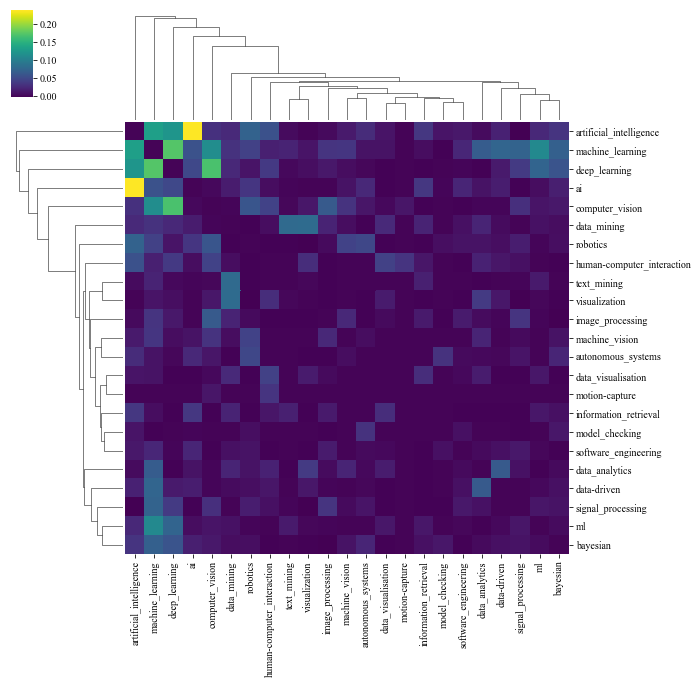

In [20]:
#Can we look for clusters

sns.clustermap(remove_diagonal(mission_keywords[mc.expanded_keywords[0]].corr()),cmap='viridis')

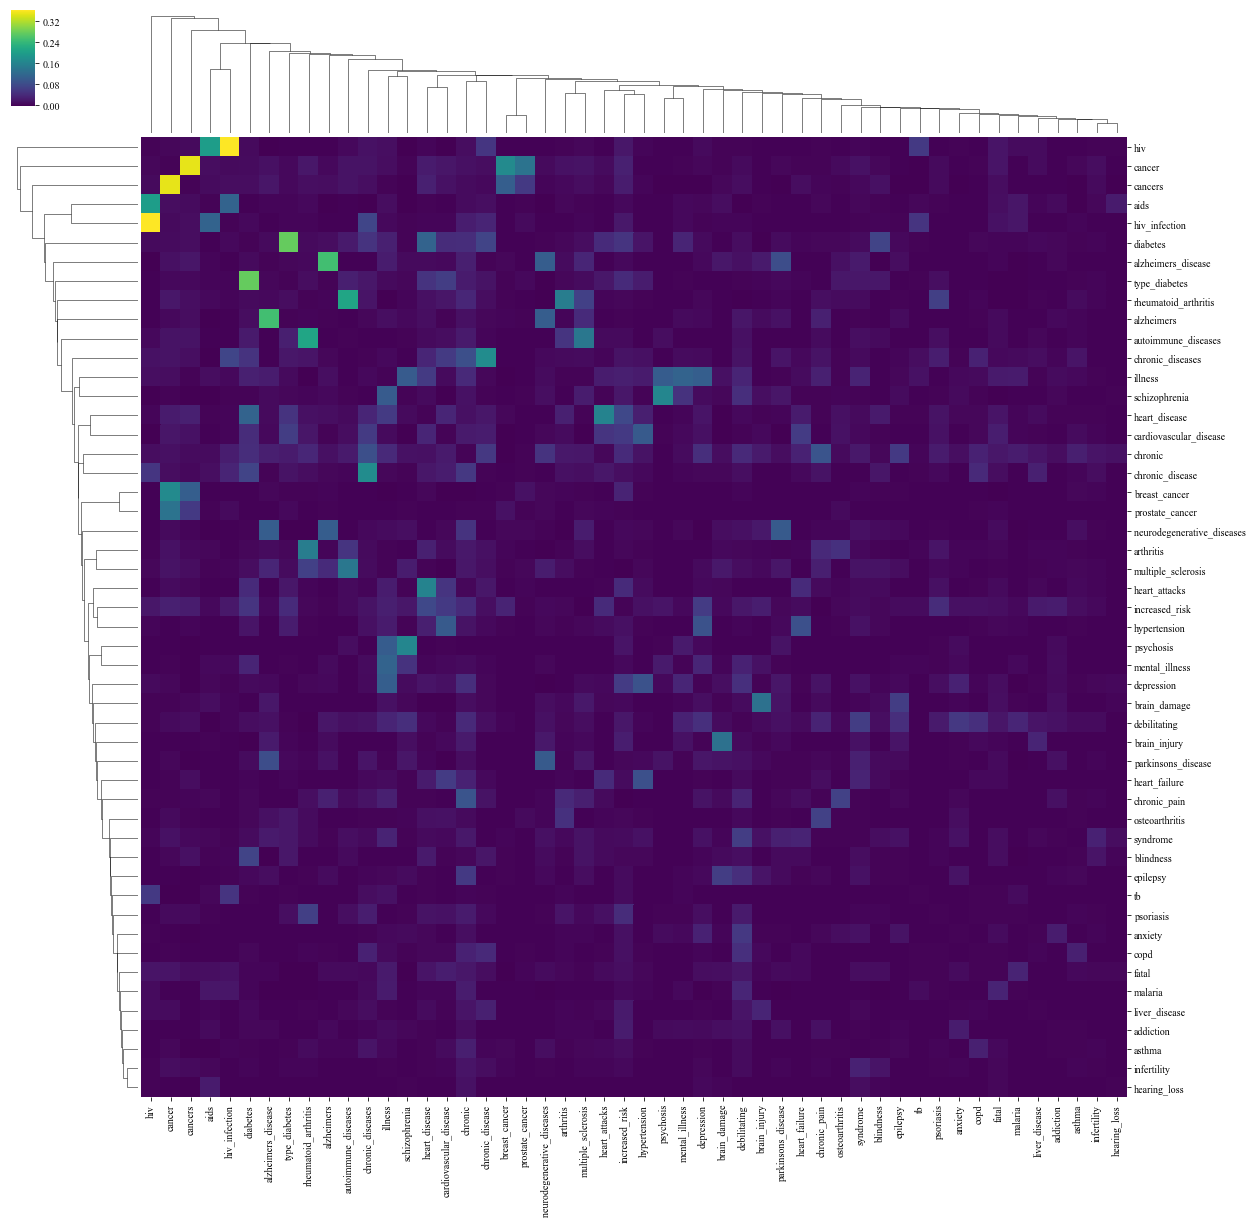

In [21]:
#Can we look for clusters

sns.clustermap(remove_diagonal(mission_keywords[high_chronic_kws].corr()),cmap='viridis',figsize=(20,20))

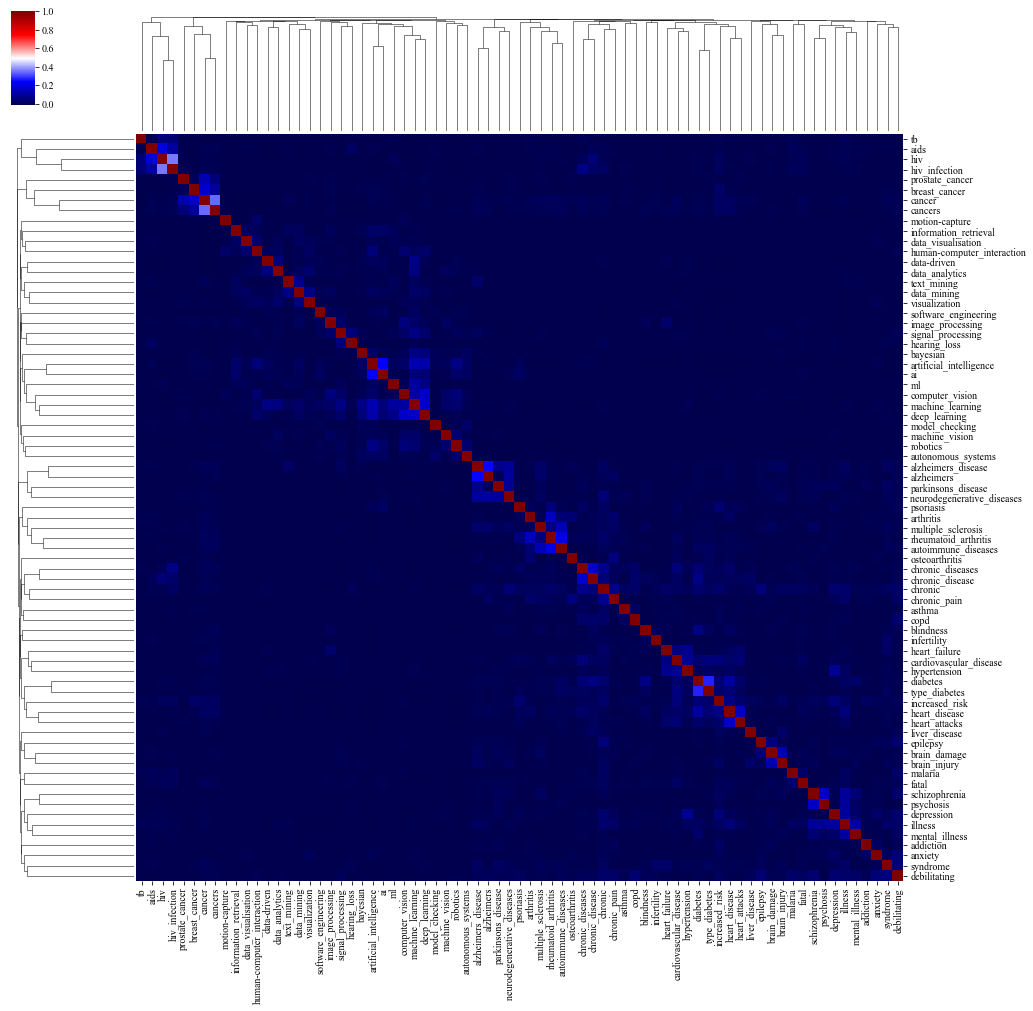

In [22]:
ai_to_chronic_corr = mission_keywords[mc.expanded_keywords[0]+high_chronic_kws].corr()

sns.clustermap(ai_to_chronic_corr,cmap='seismic',figsize=(16,16))

Unsurprisingly, the clusters are inside disciplines rather than across them.

Let's visualise topic co-occurrence as a network.


### Network analysis of keywords co-occurrence

In [23]:
from itertools import combinations
import networkx as nx

In [24]:
from itertools import combinations
import networkx as nx

def make_network_from_doc_term_matrix(dt_matrix,weight_filter=False,edgelist=False):    
    '''
    Takes a document-term matrix and returns a network.
    Offers the option to filter the network based on its weights (the parameter is a quantile if !=False)
    
    '''
    
    
    #Melt the data so we have a project-kw df
    long_topics = pd.melt(dt_matrix.reset_index(drop=False),id_vars='index')

    #Remove terms not happening in a project (Note that this throws away instances where a term occurs multiple times in a doc)
    topics_grouped = long_topics.loc[long_topics.value>0,:].groupby('index')['variable'].apply(lambda x: list(x))
    
    #And now we want to tun this into an edge list
    #This extracts pairs of combinations from topics in a project, sorts them and counts how many there are.

    edge_list = pd.Series('&&'.join(pair) for pair in flatten_list(
        [sorted(combinations(x,2),key=lambda x: x[0],reverse=False) for x in topics_grouped])).value_counts()
    
    
    #This creates the edge list in a format that can be read by nx
    edge_list = pd.concat([pd.Series({'source':v.split('&&')[0],
                                      'target':v.split('&&')[1], 'weight':l}) for v,l in zip(edge_list.index,edge_list)],axis=1).T
    
    
    #Create the network
    net = nx.from_pandas_edgelist(edge_list,edge_attr='weight')

    if weight_filter!=False:
        
        #Filter edges to focus on larger connections

        #Find the top quantile
        quant = pd.Series(list(dict(net.degree).values())).quantile(q=weight_filter)

        sub_g = [(u,w) for u,w,attr in net.edges.data(data=True) if attr['weight']>quant]

        net = net.edge_subgraph(sub_g)
        
    if edgelist==False:
        return(net)
    else:
        return(edge_list)

In [25]:
net = make_network_from_doc_term_matrix(dt_matrix=mission_keywords,weight_filter=0.3)

In [26]:
#Label categories
for n in net.node:
    
    if (n in mc.expanded_keywords[0]) & (n in mc.expanded_keywords[1]):
        net.node[n]['category'] = 'both'
    elif n in mc.expanded_keywords[0]:
        net.node[n]['category'] = 'ai'
    else:
        net.node[n]['category'] = 'chronic'

In [27]:
from webweb import Web

# create the web
web = Web(nx_G=net)

# scale edge widths by weight so we can see a visual difference
web.display.scaleLinkWidth = True

# show the visualization
#web.show()
#web.save('../reports/figures/web_web.pdf')

## Mission field analysis

#### Run the mission profiler

In [28]:
#Initialise the mission classifier and extract the data
mc = missionClassifier(mk)

#Post exploration we remove some very generic terms
kws_to_drop = ['fatal','illness','camels','syndrome','software_engineering']
mc.filter_keywords(kws_to_drop)

mc.query_data()

ai
chronic_condition


In [29]:
#Initialise the mission profiler

mprof = missionProfiler(mc)

In [30]:
mprof.mission_field_basics().mission_trends(funding='amount').funder_trends(funding='amount').discipline_analysis().impact_mix()

{'ai_or_chronic_condition': 12778, 'ai_and_chronic_condition': 281, 'ai_total': 3193, 'chronic_condition_total': 9866}


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:208: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Summary chart

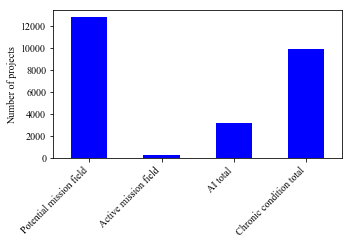

In [31]:
fig,ax = plt.subplots(figsize=(5,3.5))

pd.DataFrame(mprof.mission_summary,index=['total']).T.plot.bar(color=['blue','red','orange','red'],ax=ax,legend=False)

ax.set_xticklabels(['Potential mission field','Active mission field','AI total','Chronic condition total'],rotation=45,
                   ha='right')

ax.set_ylabel('Number of projects')

plt.tight_layout()

plt.savefig('../reports/figures/working_paper/fig_2_summary.pdf')

In [32]:
100*mprof.mission_summary['ai_and_chronic_condition']/mprof.mission_summary['ai_or_chronic_condition']

2.1990921897010485

### Print some examples

In [33]:
example_projs = mprof.projects_labelled.loc[(
    mprof.projects_labelled.ai>0) & (mprof.projects_labelled.chronic_condition>0)][['title','abstract']]

random = example_projs.iloc[np.random.randint(0,len(example_projs),3)]

random_list = [[x,y] for x,y in zip(random['title'],random['abstract'])]

          
          
for el in random_list:
    print('TITLE: '+el[0])
    print('====')
    print('ABSTRACT EXCERPT: '+el[1][:800])
    print('\n')



TITLE: HermiT: Reasoning with Large Ontologies
====
ABSTRACT EXCERPT: Ontologies are formal vocabularies of terms, often shared by a community of users. One of the most prominent application areas of ontologies is medicine and the life sciences. For example, the Systematised Nomenclature of Medicine Clinical Terms (SNOMED CT) is a clinical ontology which is being used in the UK Health Service's National Programme for Information Technology (NPfIT). Other examples include GALEN, the Foundational Model of Anatomy (FMA), the National Cancer Institute (NCI) Thesaurus, and the OBO Foundry -- a repository containing about 80 biomedical ontologies.These ontologies are gradually superseding existing medical classifications and will provide the future platforms for gathering and sharing medical knowledge. Capturing medical records using ontologies will reduce the pos


TITLE: Enabling Clinical Decisions From Low-power MRI In Developing Nations Through Image Quality Transfer
====
ABSTRACT EXCERP

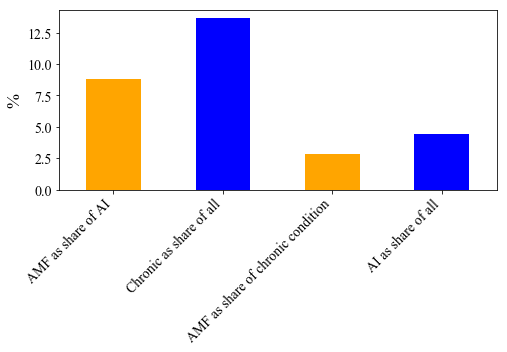

In [34]:
fig,ax = plt.subplots(figsize=(7,5))

mprof.mission_basics.plot.bar(color=['orange','blue','orange','blue'],ax=ax)

ax.set_xticklabels(['AMF as share of AI','Chronic as share of all',
                    'AMF as share of chronic condition','AI as share of all'],rotation=45,ha='right',size=14)

ax.yaxis.set_tick_params(labelsize=14)


ax.set_ylabel('%',size=18)

plt.tight_layout()

plt.savefig('../reports/figures/working_paper/fig_3_representation.pdf')

In [35]:
print(1-mprof.mission_basics[0]/mprof.mission_basics[1])
print(1-mprof.mission_basics[2]/mprof.mission_basics[3])

0.3545823461252059
0.3545823461252058


#### Trends

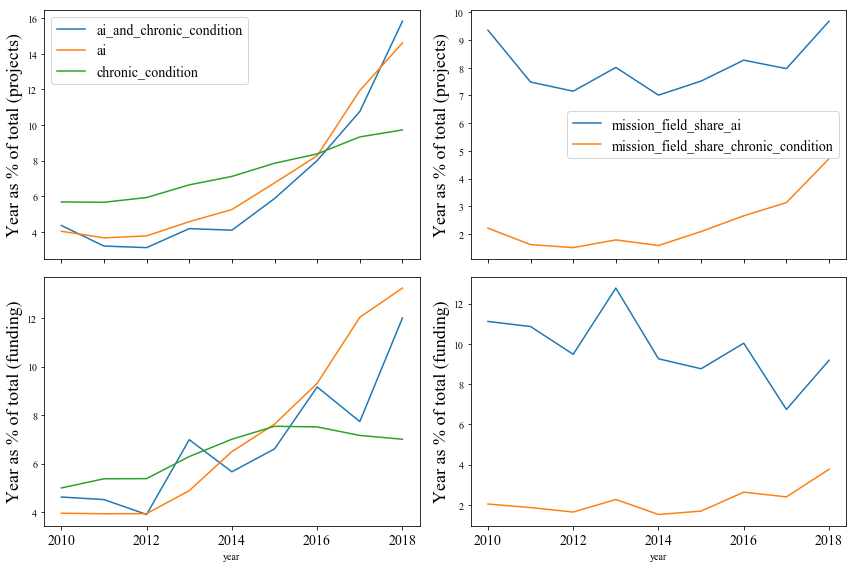

In [36]:
fig, ax = plt.subplots(nrows=2,figsize=(12,8),ncols=2,
                    sharex='row'
                      )

(100*mprof.trends['project_trends']).rolling(window=4).mean().plot(ax=ax[0][0])
(100*mprof.trends['funding_trends']).rolling(window=4).mean().plot(ax=ax[1][0],legend=False)

(100*mprof.trends['project_shares']).iloc[:,-2:].rolling(window=4).mean().plot(ax=ax[0][1])
(100*mprof.trends['funding_shares']).iloc[:,-2:].rolling(window=4).mean().plot(ax=ax[1][1],legend=False)

ax[0][0].set_ylabel('Year as % of total (projects)',size=18)
ax[1][0].set_ylabel('Year as % of total (funding)',size=18)

ax[0][1].set_ylabel('Year as % of total (projects)',size=18)
ax[1][1].set_ylabel('Year as % of total (funding)',size=18)


ax[0][0].legend(fontsize=14)
ax[0][1].legend(fontsize=14)


ax[1][0].xaxis.set_tick_params(labelsize=14)
ax[1][1].xaxis.set_tick_params(labelsize=14)

plt.tight_layout()

plt.savefig('../reports/figures/working_paper/fig_4_trends.pdf')

#### Funding

The funder for the mission fied might be different from the funder for the constituent parts. I would expect the mission funder to be related (closer) to the challenge.

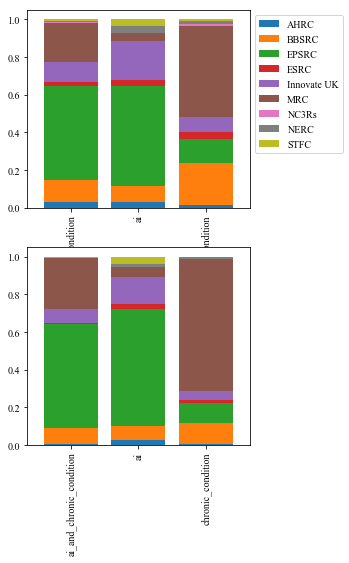

In [37]:
fig, ax = plt.subplots(figsize=(4,8),nrows=2)

mprof.funders['funder_projects'].T.plot.bar(stacked=True,ax=ax[0],width=0.8)
mprof.funders['funder_funding'].T.plot.bar(stacked=True,ax=ax[1],width=0.8)

ax[0].legend(bbox_to_anchor=(1,1))
ax[1].legend().set_visible(False)

#### Discipline mix

The effective mission field will contain a higher level of discipline diversity than the constituent parts (although here we need to remember that the constituent parts might also be related to other missions we are not capturing).

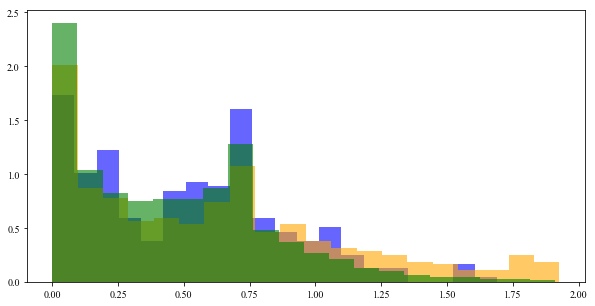

In [38]:
fig,ax = plt.subplots(figsize=(10,5))

_ = [ax.hist(df['entropy'],bins=20,color=col,alpha=0.6,density=True) for df,col in zip(mprof.sets,['blue','orange','green'])]

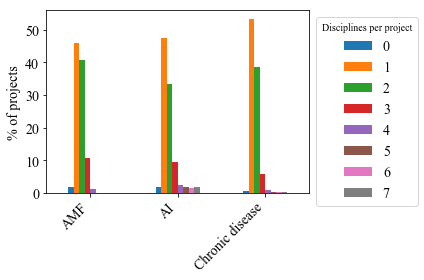

In [39]:
fig,ax = plt.subplots(figsize=(6,4))

(100*mprof.discipline_mix.T).plot.bar(ax=ax)

ax.set_xticklabels(['AMF','AI','Chronic disease'],rotation=45,ha='right',fontsize=14)

ax.legend(bbox_to_anchor=[1,1],title='Disciplines per project',fontsize=14)
ax.set_ylabel('% of projects',fontsize=14)
ax.yaxis.set_tick_params(labelsize=14)

plt.tight_layout()

plt.savefig('../reports/figures/working_paper/fig_7_disc_mix.pdf')


##### Classify projects into their top discipline and track its evolution

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


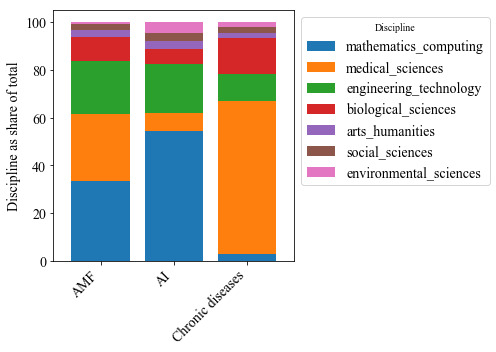

In [40]:
fig,ax= plt.subplots(figsize=(7,5))

plot_df = pd.concat([df[discs].idxmax(axis=1).value_counts(normalize=True) for df in mprof.sets],axis=1)

discs_ord = plot_df.sort_values(0).index

(100*plot_df.loc[discs_ord[::-1]]).T.plot.bar(stacked=True,ax=ax,width=0.8)

ax.set_xticklabels(['AMF','AI','Chronic diseases'],rotation=45,ha='right',size=14)
ax.legend(bbox_to_anchor=[1,1],title='Discipline',fontsize=14)
ax.set_ylabel('Discipline as share of total',size=14)
ax.yaxis.set_tick_params(labelsize=14)

plt.tight_layout()
plt.savefig('../reports/figures/working_paper/fig_5_disc_mix.pdf')

### Discipline mix over time

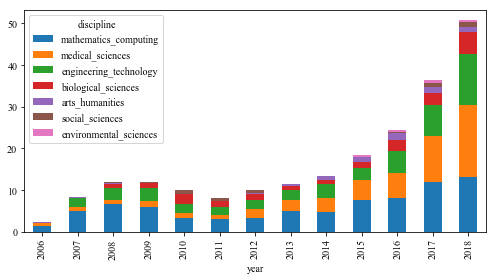

In [41]:
fig,ax = plt.subplots(figsize=(7,4))

pd.crosstab(
    mprof.sets[0].year,mprof.sets[0][discs].idxmax(axis=1),normalize=False).rolling(
    window=3).mean().loc[np.arange(2006,2019),discs_ord[::-1]].plot.bar(stacked=True,ax=ax)

ax.legend(title='discipline')

plt.tight_layout()

plt.savefig('../reports/figures/working_paper/fig_6_disc_evol.pdf')

### Discipline crossover

In [42]:
sorted_discs = mprof.sets[0][discs].sum().sort_values().index[::-1]

In [43]:
# th = 0.2

# fig,ax =plt.subplots(figsize=(10,4),ncols=3,sharey=True)

# sns.heatmap(remove_diagonal(
#     jacc_dists[0],val=np.nan),cmap='seismic',ax=ax[0])

# ax[0].set_title('Active mission field')

# sns.heatmap(remove_diagonal(
#     jacc_dists[1],val=np.nan),cmap='seismic',ax=ax[1])

# ax[1].set_title('AI')

# sns.heatmap(remove_diagonal(
#     jacc_dists[2],val=np.nan),cmap='seismic',ax=ax[2])

# ax[2].set_title('Chronic disease')

# plt.tight_layout()

# plt.savefig('../reports/figures/working_paper/fig_8_disc_mix.pdf')


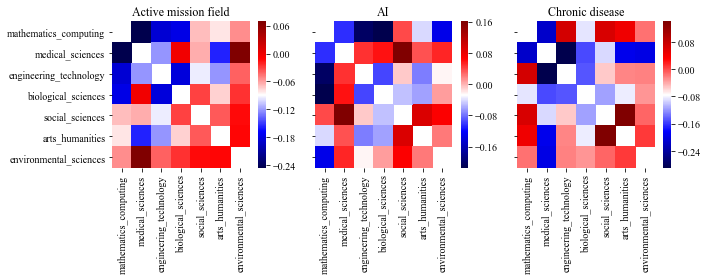

In [44]:
th = 0.2

fig,ax =plt.subplots(figsize=(10,4),ncols=3,sharey=True)

sns.heatmap(remove_diagonal(
    mprof.sets[0][sorted_discs].applymap(lambda x: 1 if x>th else 0).corr(),val=np.nan),cmap='seismic',ax=ax[0])

ax[0].set_title('Active mission field')

sns.heatmap(remove_diagonal(
    mprof.sets[1][sorted_discs].applymap(lambda x: 1 if x>th else 0).corr(),val=np.nan),cmap='seismic',ax=ax[1])

ax[1].set_title('AI')

sns.heatmap(remove_diagonal(
    mprof.sets[2][sorted_discs].applymap(lambda x: 1 if x>th else 0).corr(),val=np.nan),cmap='seismic',ax=ax[2])

ax[2].set_title('Chronic disease')

plt.tight_layout()

plt.savefig('../reports/figures/working_paper/fig_8_disc_mix.pdf')


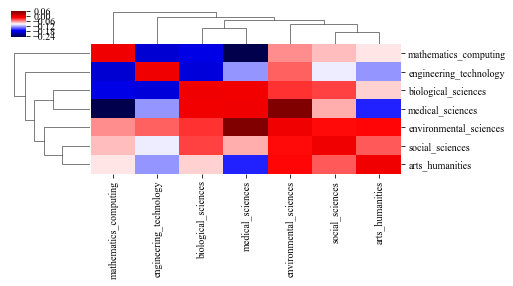

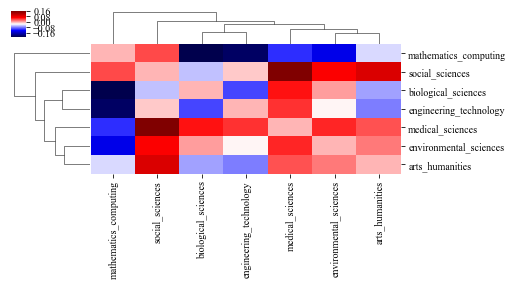

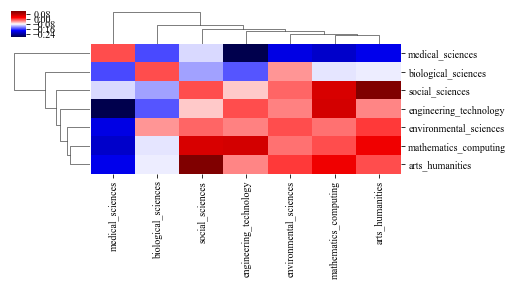

In [45]:
th = 0.2
sns.clustermap(remove_diagonal(
    mprof.sets[0][discs].applymap(lambda x: 1 if x>th else 0).corr()),cmap='seismic',figsize=(7,3))

sns.clustermap(remove_diagonal(
    mprof.sets[1][discs].applymap(lambda x: 1 if x>th else 0).corr()),cmap='seismic',figsize=(7,3))

sns.clustermap(remove_diagonal(
    mprof.sets[2][discs].applymap(lambda x: 1 if x>th else 0).corr()),cmap='seismic',figsize=(7,3))

### Identify crossover collaborations

We use a modified version of the function that extracts networks from document-term matrices

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


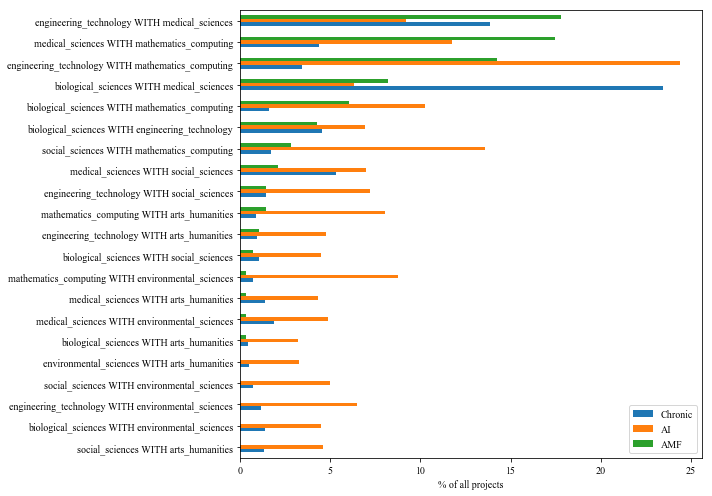

In [46]:
fig,ax = plt.subplots(figsize=(10,7))

freqs = [make_network_from_doc_term_matrix(df[discs].applymap(lambda x: 1 if x>0.1 else 0),edgelist=True)
                   for df in mprof.sets]

freqs_processed = []

for num,x in enumerate(freqs):
    x['comb'] = [x+' WITH '+y for x,y in zip(x['source'],x['target'])]
    
    x.set_index('comb',inplace=True)
    
    freqs_processed.append(x['weight']/len(mprof.sets[num]))
    
out = pd.concat(freqs_processed,axis=1).fillna(0)

out.columns = ['AMF','AI','Chronic']


(100*out.sort_values('AMF')[out.columns[::-1]]).plot.barh(ax=ax)

ax.set_xlabel('% of all projects')


plt.tight_layout()

plt.savefig('../reports/figures/working_paper/fig_9_disc_combs.pdf')



### Top disciplines

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


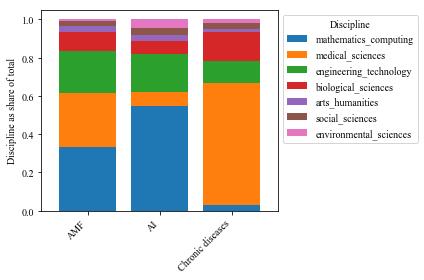

In [47]:
fig,ax= plt.subplots()


plot_df = pd.concat([df[discs].idxmax(axis=1).value_counts(normalize=True) for df in mprof.sets],axis=1)

discs_ord = plot_df.sort_values(0).index

plot_df.loc[discs_ord[::-1]].T.plot.bar(stacked=True,ax=ax,width=0.8)

ax.set_xticklabels(['AMF','AI','Chronic diseases'],rotation=45,ha='right')
ax.legend(bbox_to_anchor=[1,1],title='Discipline')
ax.set_ylabel('Discipline as share of total')

plt.tight_layout()
plt.savefig('../reports/figures/working_paper/fig_5_disc_mix')

### Impacts

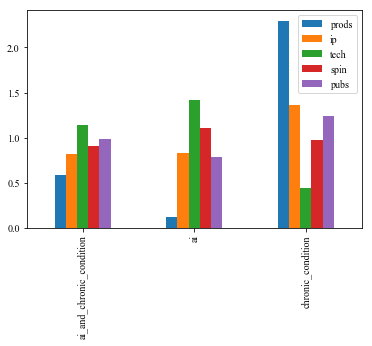

In [48]:
mprof.impacts[1].plot.bar()

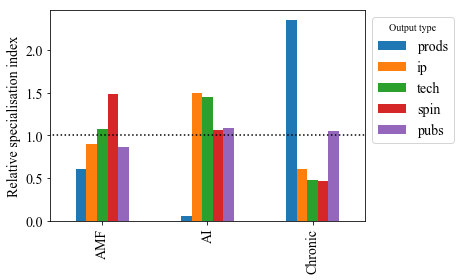

In [49]:
#Here we focus on the more recent period (taking into account that the AI / chronic projects tend to be more recent)
fig,ax = plt.subplots(figsize=(6.5,4))


mprof.impact_mix(years=[2014,2018]).impacts[1].plot.bar(ax=ax)


ax.set_ylabel('Relative specialisation index',size=14)
ax.hlines(y=1,xmin=-1,xmax=3,linestyles=':')

ax.set_xticklabels(['AMF','AI','Chronic'],size=14)
ax.legend(bbox_to_anchor=[1,1],title='Output type',fontsize=14)
ax.yaxis.set_tick_params(labelsize=14)

plt.tight_layout()

plt.savefig('../reports/figures/working_paper/fig_10_outputs.pdf')


In [50]:
100*mprof.sets[0][imps].applymap(lambda x: x>0).mean()

prods     2.491103
ip        4.982206
tech     10.320285
spin      1.067616
pubs     46.975089
dtype: float64

### Network analysis

Now we want to visualise the organisational network of the mission field: what organisations are connected with each other in this network?

Who are the key players in each of the three 'fields' (chronic, AI and AI-chronic), in total number of projects and relative specialisation?







In [51]:
links = pd.read_csv('../data/external/gtr/2019-01-24/gtr_link_table.csv')
orgs = pd.read_csv('../data/external/gtr/2019-01-24/gtr_organisations.csv')

The logic below is:

``merge projects and links on project ids, and merge that with organisations on entity ids``


In [52]:
#We want to avoid cofunding organisations, fellow organisations etc

my_vars = ['COLLAB_ORG','LEAD_ORG','PARTICIPANT_ORG']

In [53]:
project_orgs = pd.merge(
    pd.merge(mprof.projects_labelled,links.loc[links.table_name=='gtr_organisations'],left_on='index',right_on='project_id'),
    orgs[['id','name']],left_on='id',right_on='id')

projects_orgs = project_orgs.loc[[x in my_vars for x in project_orgs['rel']],:]

In [54]:
project_orgs['ai_and_chronic_condition'] = [(x>0) & (y>0) for x,y in zip(project_orgs['ai'],project_orgs['chronic_condition'])]

#### Are organisations in active mission fields younger?

Here we proxy age through the earliest when an organisation appears in the data

In [55]:
def calculate_ages(three_sets,org_df,stat):
    '''
    Calculates the mean ages for organisations participating in different mission fields
    
    '''
    
    new_df = org_df.copy()
    
    #AMF = active mission field
    new_df['ai'],new_df['chronic'], new_df['amf'] = [[x in v for x in new_df.index] for v in three_sets]
    
    #Calculate mean age of organisations in a field (time since they first appeared in the data)
    youth = pd.concat([2019-new_df.groupby(var)['year'].apply(lambda x: stat(x)) for var in ['amf','ai','chronic']],axis=1)
    youth.columns=['amf','ai','chronic']
    
    return(youth)

In [56]:
#Min age of appearance by organisation
org_metadata = pd.concat([
    project_orgs.groupby('name')['year'].apply(lambda x: min(x)),
    project_orgs.groupby('name').size()],axis=1)
    
org_metadata.rename(columns={0:'project_number'},inplace=True)


In [57]:
#All organisations in the field
org_sets =[set(project_orgs.loc[project_orgs[var]>0]['name']) for var in ['ai','chronic_condition','ai_and_chronic_condition']]

#Organisations that *only* participate in the field
org_set_specs =[
    set(project_orgs.loc[project_orgs[var]>0]['name'])-set(project_orgs.loc[project_orgs[var]==0]['name']) for var in ['ai','chronic_condition','ai_and_chronic_condition']]

In [58]:
out = pd.concat([calculate_ages(org_sets,org_metadata,np.mean).loc[True],
          calculate_ages(org_set_specs,org_metadata,np.mean).loc[True]],axis=1)

out.columns = ['All','Specialised']

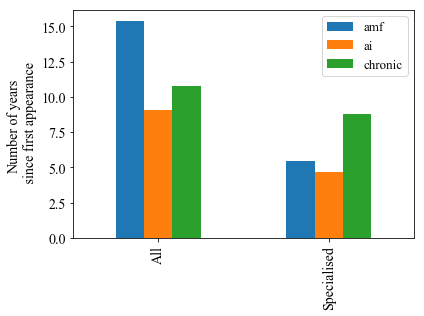

In [59]:
fig,ax = plt.subplots(figsize=(6,4.5))

out.T.plot.bar(ax=ax)

ax.set_ylabel('Number of years \n since first appearance',size=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.xaxis.set_tick_params(labelsize=14)


ax.legend(fontsize=13)

plt.tight_layout()

plt.savefig('../reports/figures/working_paper/fig_11_youth.pdf')

In [60]:
def calculate_experience(three_sets,org_df,stat):
    '''
    Calculates the experience for organisations participating in different mission fields
    
    '''
    
    new_df = org_df.copy()
    
    #AMF = active mission field
    new_df['ai'],new_df['chronic'], new_df['amf'] = [[x in v for x in new_df.index] for v in three_sets]
    
    #Calculate mean age of organisations in a field (time since they first appeared in the data)
    youth = pd.concat([new_df.groupby(var)['project_number'].apply(lambda x: stat(x)) for var in ['amf','ai','chronic']],axis=1)
    youth.columns=['amf','ai','chronic']
    
    return(youth)

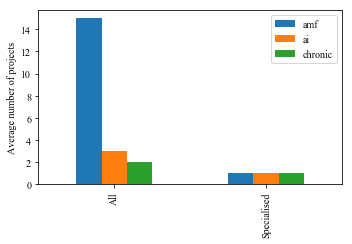

In [61]:
out_2 = pd.concat([calculate_experience(org_sets,org_metadata,np.median).loc[True],
          calculate_experience(org_set_specs,org_metadata,np.median).loc[True]],axis=1)

out_2.columns = ['All','Specialised']

fig,ax = plt.subplots(figsize=(5,3.5))

out_2.T.plot.bar(ax=ax)

ax.set_ylabel('Average number of projects')

plt.tight_layout()

plt.savefig('../reports/figures/working_paper/fig_12_experience.pdf')

### Total organisation frequencies

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


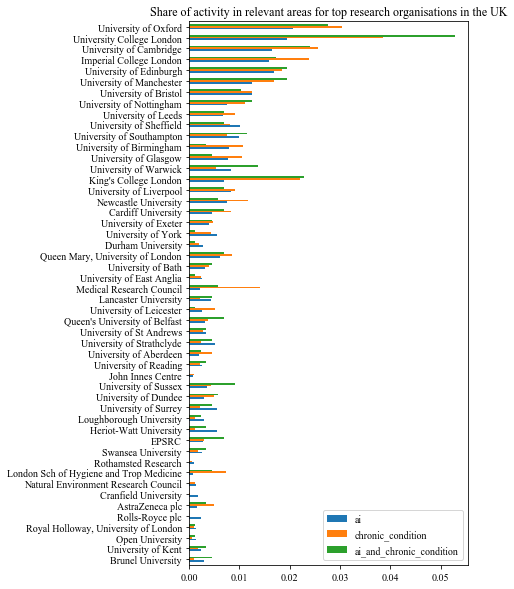

In [62]:
total_org_freqs = project_orgs['name'].value_counts(normalize=1)

var_names = ['ai','chronic_condition','ai_and_chronic_condition']

mission_org_freqs = pd.concat([
    project_orgs.loc[project_orgs[var]>0,'name'].value_counts(normalize=1) for var in var_names],axis=1).fillna(0)

mission_org_freqs.columns=var_names

fig,ax = plt.subplots(figsize=(5,10))

mission_org_freqs.loc[total_org_freqs.index[:50]][::-1].plot.barh(ax=ax,title=
                                                                  'Share of activity in relevant areas for top research organisations in the UK')

Note that the EPSRC and the MRC are still there (?)

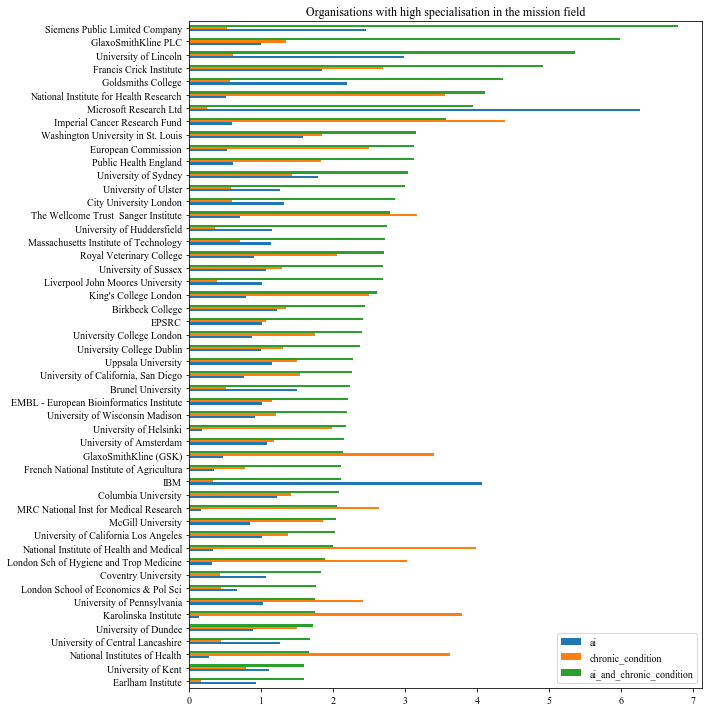

In [63]:
# Now do it with some normalisation

mission_org_freqs_norm = pd.concat([
    project_orgs.loc[project_orgs[var]>0,'name'].value_counts(normalize=1)/total_org_freqs for var in var_names],axis=1).fillna(0)

mission_org_freqs_norm.columns=var_names

fig,ax = plt.subplots(figsize=(10,10))

mission_org_freqs_norm.loc[total_org_freqs.index[:200]].sort_values('ai_and_chronic_condition',ascending=True)[-50:].plot.barh(
    ax=ax,title='Organisations with high specialisation in the mission field')

ax.set_yticklabels([x.get_text()[:40] for x in ax.get_yticklabels()])

plt.tight_layout()

plt.savefig('../reports/figures/working_paper/fig_13_top_actors.pdf')

In [64]:
top_50_total = set(mission_org_freqs.loc[total_org_freqs.index[:50]].index)
top_50_mission = set(mission_org_freqs_norm.loc[total_org_freqs.index[:200]].sort_values('ai_and_chronic_condition',ascending=False)[:50].index)


set(top_50_mission) & set(top_50_total)



{'Brunel University',
 'EPSRC',
 "King's College London",
 'London Sch of Hygiene and Trop Medicine',
 'University College London',
 'University of Dundee',
 'University of Kent',
 'University of Sussex'}

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


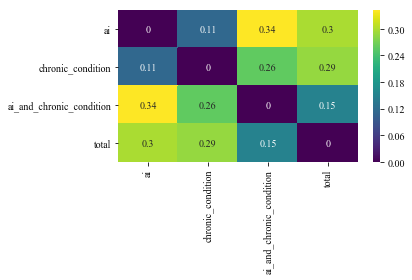

In [65]:
#Compare share of total AI, Chronic, Chronic condition

mission_distribution = pd.concat([pd.concat([project_orgs.loc[project_orgs[var]>0,'name'].value_counts(normalize=1) for var in var_names],axis=1).fillna(0),
                                  total_org_freqs],axis=1).fillna(0)

mission_distribution.columns=var_names + ['total']

sns.heatmap(remove_diagonal(mission_distribution.corr(method='spearman')),cmap='viridis',annot=True)

plt.tight_layout()

plt.savefig('../reports/figures/working_paper/fig_14_rankings_heatmap.pdf')

Interesting - it looks like organisations that are strong in AI tend to apply it in other areas rather than the other way around.

#### Conclude with a network visualisation

In [66]:
def make_network_from_element_lists(element_list,index='index',variable='variable',weight_filter=False):    
    '''
    Takes a list where every element is a list of elements
    Offers the option to filter the network based on its weights (the parameter is a quantile if !=False)
    
    '''
    
    
    #Remove terms not happening in a project (Note that this throws away instances where a term occurs multiple times in a doc)
    topics_grouped = element_list.groupby(index)[variable].apply(lambda x: list(x))
    
    #And now we want to tun this into an edge list
    #This extracts pairs of combinations from topics in a project, sorts them and counts how many there are.

    edge_list = pd.Series('&&'.join(pair) for pair in flatten_list(
        [sorted(combinations(x,2),key=lambda x: x[0],reverse=False) for x in topics_grouped])).value_counts()
    
    
    e1,e2 = [[x.split('&&')[num] for x in edge_list.index] for num in [0,1]]

    edge_df= pd.DataFrame({'source':e1,'target':e2,'weight':edge_list}).reset_index(drop=True)
    
    
    #Create the network
    net = nx.from_pandas_edgelist(edge_df,edge_attr='weight')

    if weight_filter!=False:
        
        #Filter edges to focus on larger connections

        #Find the top quantile
        quant = pd.Series(list(dict(net.degree).values())).quantile(q=weight_filter)

        sub_g = [(u,w) for u,w,attr in net.edges.data(data=True) if attr['weight']>quant]

        net = net.edge_subgraph(sub_g)
        
    
    return(net)

In [67]:
mission_orgs = project_orgs.loc[[(x>0) | (y>0) | (z>0) for x,y,z in zip(project_orgs['ai'],
                                                                           project_orgs['chronic_condition'],
                                                                           project_orgs['ai_and_chronic_condition'])]]

org_sets = [set(project_orgs.loc[project_orgs[var]>0,'name']) for var in var_names]

In [68]:
# mission_nets = [make_network_from_element_lists(
#     project_orgs.loc[project_orgs[var]>0],index='project_id',
#      variable='name',weight_filter=0.5) for var in var_names]
# # create the web
# web = Web(display={'nodes':{num:{'name':name} for num,name in enumerate(set(mission_orgs['name']))}})
# web.networks.ai(nx_G=mission_nets[0])
# web.networks.chronic_cond(nx_G=mission_nets[1])
# web.networks.ai_and_chronic_cond(nx_G=mission_nets[2])
# # scale edge widths by weight so we can see a visual difference
# web.display.scaleLinkWidth = True

# # show the visualization
# web.show()
# #web.save('../reports/figures/web_web.pdf')

In [69]:
mission_net = make_network_from_element_lists(mission_orgs,index='project_id',variable='name',weight_filter=0.3)

In [70]:
#Label categories
for n in mission_net.node:
    
    if n in org_sets[2]:
        mission_net.node[n]['category']='mission_field'
        
    elif n in org_sets[0]:
        mission_net.node[n]['category']='ai_field'
    
    elif n in org_sets[1]:
        mission_net.node[n]['category']='chronic_field'

In [71]:
# create the web
web = Web(nx_G=mission_net)

# scale edge widths by weight so we can see a visual difference
web.display.scaleLinkWidth = True

web.show()

### [Done]


* Produce a better query system: a better seed list would help.
* Package the descriptive stat generator into a function or class. This should be generic enough to accept dfs from other sources (eg H2020 and OpenAIRE).
* Reimplement and test the above. Check how many of the new projects were already captured by the two broader categories


### Next steps
* Organisation visualisation
* Other indicators
* Apply functions to other data and / or challenge.

### Other combinations
* Integrate with TRL analysis
* Integrate with SDG analysis
* Check social media discussion around papers


## Doc2Vec project expansion

We train a doc2vec model that looks for projects which are semantically closed to those we identify as highly relevant for the challenge

In [72]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [73]:
tagged_documents = [TaggedDocument(doc,[num]) for num,doc in enumerate(corpus_tokenised.tokenised)]

In [479]:
d2v = Doc2Vec(tagged_documents,vector_size=400)

### Identify active mission field projects

In [480]:
mission_set_indices = list(mprof.sets[0].index)

In [481]:
mission_document_vectors = pd.concat([pd.Series(x) for num,x in enumerate(d2v.docvecs.vectors_docs) if num in mission_set_indices],axis=1).T

In [482]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



#### Calculate silouhette scores for different K values in the kmeans

In [483]:
results = []

for k in np.arange(3,15):
    
    
    ss = []
    for i in np.arange(0,20):
        
        km = KMeans(n_clusters=k)

        preds = km.fit_predict(mission_document_vectors)
    
        ss_i =silhouette_score(mission_document_vectors,preds)
        ss.append(ss_i)
            
    results.append([k,np.mean(ss)])
    
    #predictions = pd.Series(km.fit_predict(mission_document_vectors))

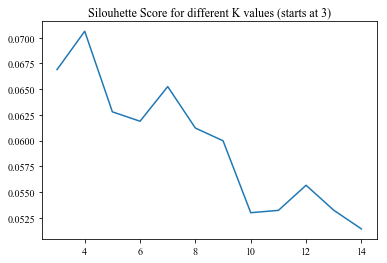

In [484]:
pd.Series([x[1] for x in results],index=[x[0] for x in results]).plot(title='Silouhette Score for different K values (starts at 3)')

We are going to choose 7. This is flakey



In [485]:
#predictions = pd.Series(km.fit_predict(mission_document_vectors))

km = KMeans(n_clusters=8,n_init=80)

predictions = pd.Series(km.fit_predict(mission_document_vectors))

index_lookup = {i:c for i,c in zip(mission_set_indices,predictions)}

Label the projects

In [486]:
mission_projects = mprof.sets[0].copy()

mission_projects['cluster'] = [index_lookup[i] for i in mission_projects.index]

Create sub-corpora based on the clusters

In [487]:
word_lists = mission_projects.groupby('cluster')['abstract'].apply(lambda x: ' '.join(x))

In [488]:
for x in set(mission_projects['cluster']):
    
    print(x)
    
    print('======')
    random_check(mission_projects.loc[mission_projects.cluster==x,'abstract'],num=3,length=500)
    
    print('\n')
    

0
As a society, more and more of the activities that we take for granted
rely on sophisticated technology, and are dependent on the fast and
efficient handling of large quantities of data. Obvious examples
include the use of internet search engines and mobile telephones.
Similarly, recent advances in healthcare are partly due to improved,
highly data-intensive scanning equipment in hospitals, and the
development of new, effective drug treatments, which have been the
result of extensive scientific 
====
The study of shapes is a central problem in medical imaging, computer vision and many engineering fields. Suppose we are given the silhouette of a human organ, such as the brain or colon, from an X-ray scan. Human organs change their shape because of disease progression, surgery and other treatments, and simply by natural growth. How are we to tell from such a silhouette, or 2D shape, whether the organ is diseased (as in the brain of an Alzheimer's patient for example) and, if so, the de

Get salient words using a rather crude approach

In [489]:
from wordcloud import WordCloud

all_text_freqs = pd.Series([x.lower() for x in ' '.join([x for x in word_lists]).split(' ') if x.lower() not in stop]).value_counts()

top_words = all_text_freqs[:1000].index

to_show = []

for n,t in enumerate(word_lists):
    
    print(n)
    
    cluster_freq = pd.Series([x.lower() for x in word_lists[n].split(' ') if x.lower() not in stop]).value_counts()
    cluster_norm_freq= pd.concat([cluster_freq,all_text_freqs],axis=1)
    cluster_norm_freq['share'] = cluster_norm_freq[0]/cluster_norm_freq[1]
    
    out = cluster_norm_freq.loc[top_words].sort_values('share',ascending=False)[:50]
    
    out_dict = {w:c for w,c in zip(out.index,out[0])}
    
    to_show.append(out_dict)


0
1
2
3
4


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


5
6
7


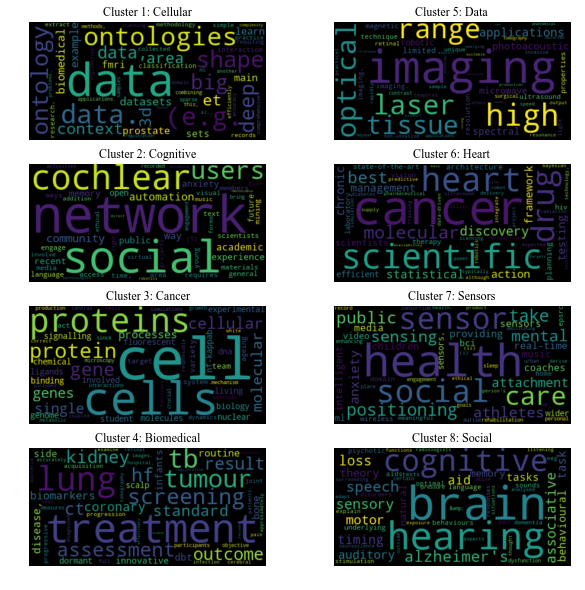

In [490]:
fig,ax = plt.subplots(ncols=2,nrows=4,figsize=(10,10))

for num,s in enumerate(to_show):    
    wc = WordCloud()
    wc.fit_words(s)
    
    if num<4:
        ax[num][0].imshow(wc, interpolation="bilinear")
        ax[num][0].axis('off')
    else:
        ax[num-4][1].imshow(wc, interpolation="bilinear")
        ax[num-4][1].axis('off')
        
ax[3][1].axis('off')

ax[0][0].set_title('Cluster 1: Cellular')
ax[1][0].set_title('Cluster 2: Cognitive')
ax[2][0].set_title('Cluster 3: Cancer')
ax[3][0].set_title('Cluster 4: Biomedical')
ax[0][1].set_title('Cluster 5: Data')
ax[1][1].set_title('Cluster 6: Heart')
ax[2][1].set_title('Cluster 7: Sensors')
ax[3][1].set_title('Cluster 8: Social')

plt.savefig('../reports/figures/working_paper/fig_15_wordclouds.pdf')

In [491]:
cluster_name_lookup = {n:name for n,name in enumerate(['Cellular',
                                                       'Cognitive',
                                                       'Cancer',
                                                       'Biomedical',
                                                       'Data',
                                                       'Heart',
                                                       'Sensors',
                                                       'Social'])}


mission_projects['cluster_name'] = [cluster_name_lookup[x] for x in mission_projects['cluster']]

In [492]:
sorted_clusters = mission_projects.cluster_name.value_counts().index

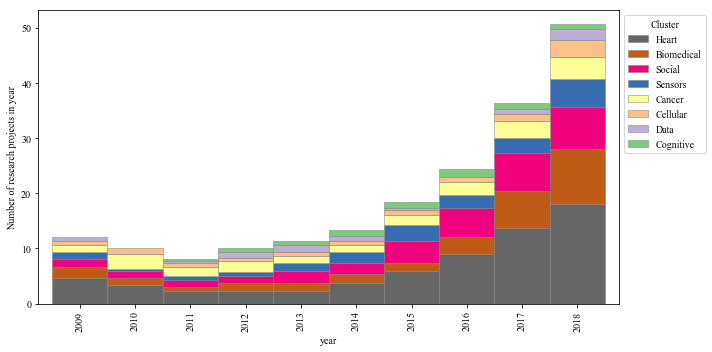

In [493]:
fig,ax = plt.subplots(figsize=(10,5))

pd.crosstab(mission_projects['year'],mission_projects['cluster_name']).loc[np.arange(2006,2019)].rolling(
    window=3).mean().loc[np.arange(2009,2019),sorted_clusters].plot.bar(
    stacked=True,ax=ax,width=1,cmap='Accent_r',linewidth=0.5,edgecolor='grey')

ax.legend(bbox_to_anchor=[1,1],title='Cluster')
ax.set_ylabel("Number of research projects in year")

plt.tight_layout()

#plt.savefig('../reports/figures/working_paper/fig_16_cluster_evol.pdf')
plt.savefig('/Users/jmateosgarcia/Desktop/2019/fig_4.eps', format='eps', dpi=1000)

In [494]:
funders_sorted = mission_projects['funder'].value_counts().index

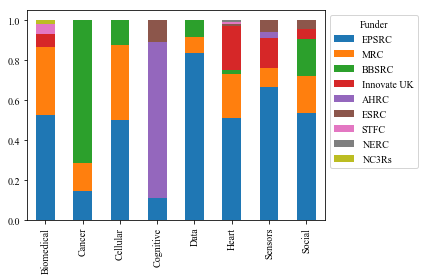

In [495]:
fig,ax = plt.subplots(figsize=(6,4))

pd.crosstab(mission_projects['cluster_name'],mission_projects['funder'],normalize=0).loc[:,funders_sorted].plot.bar(stacked=True,ax=ax)
ax.legend(bbox_to_anchor=[1,1],title='Funder')
ax.set_xlabel('')

plt.tight_layout()


plt.savefig('../reports/figures/working_paper/fig_17_cluster_funders.pdf')

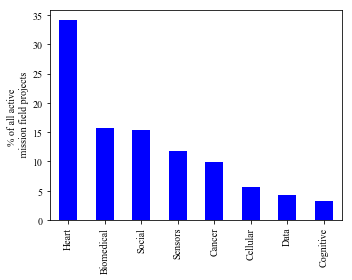

In [496]:
fig,ax = plt.subplots(figsize=(5,4))


(100*mission_projects.cluster_name.value_counts(normalize=1)).plot.bar(color='blue',ax=ax)

ax.set_ylabel('% of all active \n mission field projects')

plt.tight_layout()

plt.savefig('../reports/figures/working_paper/fig_18_cluster_distr.pdf')

## Mission field decomposition

In [497]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift,SpectralClustering
#als = list(ec.cluster_allocations.values())
import wordcloud
import networkx as nx
from itertools import combinations, product
import community
import random

class EnsembleClustering():
    '''
    This class takes a group of vectors and clusters them using a variety of algorithms. 
    It then builds a network based on these allocations which we can use for community detection.
    
    input: a df where rows = observations to cluster and columns = vector for clustering
    methods:
        run_clusters: runs a variety of clustering algorithms with parameters defined by the user
        build_network: builds the network using the clustering results
        partitition_network: extracts communities from the network
    
    '''
    
    def __init__(self,vectors):
        '''
        Takes the vectors 
        '''
        
        #Stores the vectors
        self.vector_df = vectors
        
    def run_clusters(self,cluster_list):
        '''
        Each element in the cluster_list is a cluster algorithm and a dict with parameters. We do a cartesian product of these parameters or parameter lists
        to produce a list of cluster algorithms to run and store all the allocations.
        
        '''
        
        #Load vectors
        vectors = self.vector_df
        
        #Create store
        self.cluster_allocations = {}
        
        #For each cluster family we want to test
        for element in cluster_list:
            
            #Extract the algorithm, name and cluster parameters
            cluster_algo = element[0]
            
            cluster_name = element[1]
            
            cluster_params = element[2]
            
            #Create a grid
            grid = list(product(*cluster_params.values()))
            
            #print(grid)
            
            #For each element in the grid
            
            for conf in grid:
                
                #Create a keyword argument
                par_dict = {n:v for n,v in zip(cluster_params.keys(),conf)}
                
                #Initialise the clustering algorithm
                cl = cluster_algo(**par_dict)
                
                #print(cl)
                
                #Predict labels
                labs = cl.fit_predict(vectors)
                
                #Store labels
                self.cluster_allocations[cluster_name+'_'+str(conf)] = labs
                
        return(self)
    
    def build_network(self,verbose=False):
        '''
        Builds the network
        
        '''
        
        #net = nx.Graph()
        
        edges = []
        
        for n,result in enumerate(self.cluster_allocations.values()):
            
            if verbose==True:
                print(n)
            
            grouped = pd.DataFrame({'index':ec.vector_df.index,'allocs':result}).groupby('allocs')['index'].apply(lambda x:list(x))
            
            combs = flatten_list([['__'.join([str(x) for x in var]) for var in combinations(vals,2)] for vals in grouped])
            
            edges.append(combs)
            
        
        edge_list = flatten_list(edges)
        
        
        combs_df = pd.Series(edge_list).value_counts().reset_index(drop=False)

        combs_df.columns = ['vars','weight']
        
        #This is an edgelist
        combs_df['source'],combs_df['target'] = [[x.split('__')[num] for x in combs_df['vars']] for num in [0,1]]


        combs_df.drop(['vars'],axis=1,inplace=True)
        
        #Create a network
        self.network = nx.from_pandas_edgelist(combs_df,edge_attr='weight')
            
        
    
    def partitition_network(self,resolution=1):
        '''
        
        Partitions the network
        
        '''
        
        part = community.best_partition(self.network,resolution=resolution)
        
        
        allocs = pd.Series(part)
        allocs.name = 'clusters'
        
        allocs.index = [int(x) for x in allocs.index]
        
        self.partition = allocs           

        
class SalientWords():
    '''
    Class that extracts salient words from clusters of data.
    
    Arguments:
        A dataframe and two strings (the variable to groupby and the variable to use as text)
        
    Methods:
        .count_vect(): word frequencies for all words (takes **kwargs for additional parameters in the count vectorisation)
        .salient(): tfidf. It will also take **kwargs and a threshold for including words in the results
        .visualise(): it visualises the data as wordclouds
    
    '''
    
    def __init__(self,df,categories,text):
        '''
        Initialises with key variables
        
        '''    
        
        
        #This creates the joined corpus
        self.grouped_corpus = df.groupby(categories)[text].apply(lambda x: ' '.join(x))
        
        
        #Remove digits and special 
        dig = r'|'.join(st.digits)
        out = '\W+'
        
        self.processed_text = [re.sub(out,' ',re.sub(dig,' ',x.lower())) for x in self.grouped_corpus]
        
        #This is a dict we will use to store the results later
        self.groups = {i:[] for i in self.grouped_corpus.index}
        
        #return(self)
        
    def word_freqs(self,**kwargs):
        '''
        Terms frequencies over categories
        
        '''
        #load corpus
        X = self.processed_text
        
        count_vect = CountVectorizer(**kwargs)
        
        #Store outputs
        self.count_vect = count_vect
        self.token_freqs = count_vect.fit_transform(X)
        
        return(self)
    
    def salient(self,min_threshold=1000,extra_stops=['research','project','new','projects'],**kwargs):
        '''
        Salient terms in the data.
        
        '''
        
        #Get selected words
        
        word_freqs = pd.DataFrame(self.token_freqs.todense(),columns=self.count_vect.get_feature_names())
        
        word_freqs_total = word_freqs.sum(axis=0)
        
        #Create a dict so we can put word frequencies together with salient words later
        #word_freqs_dict = word_freqs.to_dict()
        
        #I am interested in any words above the threshold
        my_words = [x for x in word_freqs_total.index[word_freqs_total>min_threshold] if x not in extra_stops]
        
        
        #Initialise the tfidf
        tf = TfidfTransformer(**kwargs)
        
        
        #out
        X = tf.fit_transform(self.token_freqs)
        
        X_selected = pd.DataFrame(X.todense(),columns=self.count_vect.get_feature_names())[my_words]
            
            
        #Store the results
        for n,x in enumerate(self.groups.keys()):
            
            #Creates the dataframe combining tfs and wfs
            result = pd.concat([X_selected.iloc[n],word_freqs.iloc[n][my_words]],axis=1)
            
            result.columns = ['tfidf','count'] 
                   
            self.groups[x] = result
            
        return(self)
        
    def get_summary(self,tf_threshold=90,wf_threshold=75):
        '''
        
        Extracts a summary of the data based on tf and wf thresholds
        
        '''
        
        self.summary={i:[] for i in self.groups.keys()}
        
        for x in self.groups.keys():
            
            #Creates the dataframe
            result = self.groups[x]
            
            tf_thres = np.percentile(result['tfidf'],tf_threshold)
            
            summary = result.loc[result['tfidf']>tf_thres]
            
            wf_thres = np.percentile(result['count'],wf_threshold)
            
            summary_2 = summary.loc[summary['count']>wf_thres]
                   
            self.summary[x] = summary_2.sort_values('tfidf',ascending=False)
        
        return(self)
    
def make_wordcloud(term_freqs_df,var,name,ax):
    '''
    This function takes a df generated by the SalientWords class and returns a wordcloud
    
    '''
    
    input_dict = {w:f for w,f in zip(term_freqs_df.index,term_freqs_df[var])}

    wc = wordcloud.WordCloud(background_color="black").generate_from_frequencies(input_dict)

    ax.imshow(wc)
    
    ax.axis('off')
    
    ax.set_title(name)

In [498]:
cluster_list = [[KMeans,'kmeans',{'n_clusters':np.arange(5,40,1),'max_iter':[200,500]}],
                [MeanShift,'ms',{'cluster_all':[True,False]}],
               [AgglomerativeClustering,'agglom',{'n_clusters':np.arange(5,40,1)}],
                [SpectralClustering,'spec',{'n_clusters':np.arange(5,40,1),'n_init':[10,20]}]]
                

In [499]:
ec = EnsembleClustering(mission_document_vectors)
ec.run_clusters(cluster_list)

In [500]:
ec.build_network()

In [501]:
ec.partitition_network(resolution=1)

In [502]:
partition = ec.partition

In [503]:
partition_sorted_lookup = partition[sorted(partition.index)].to_dict()

In [504]:
projects_salient = mission_projects.copy()

In [505]:
projects_salient['cluster'] = [partition_sorted_lookup[x] for x,y in enumerate(projects_salient.index)]

In [506]:
import string as st
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

In [507]:
traj_salient = SalientWords(df=projects_salient,categories='cluster',text='abstract')

In [508]:
traj_salient.word_freqs(**{'stop_words':'english','max_features':20000,'ngram_range':(1,3),'max_df':3}).salient(min_threshold=30).get_summary(
    wf_threshold=50,tf_threshold=75)

In [509]:
len(traj_salient.summary)

5

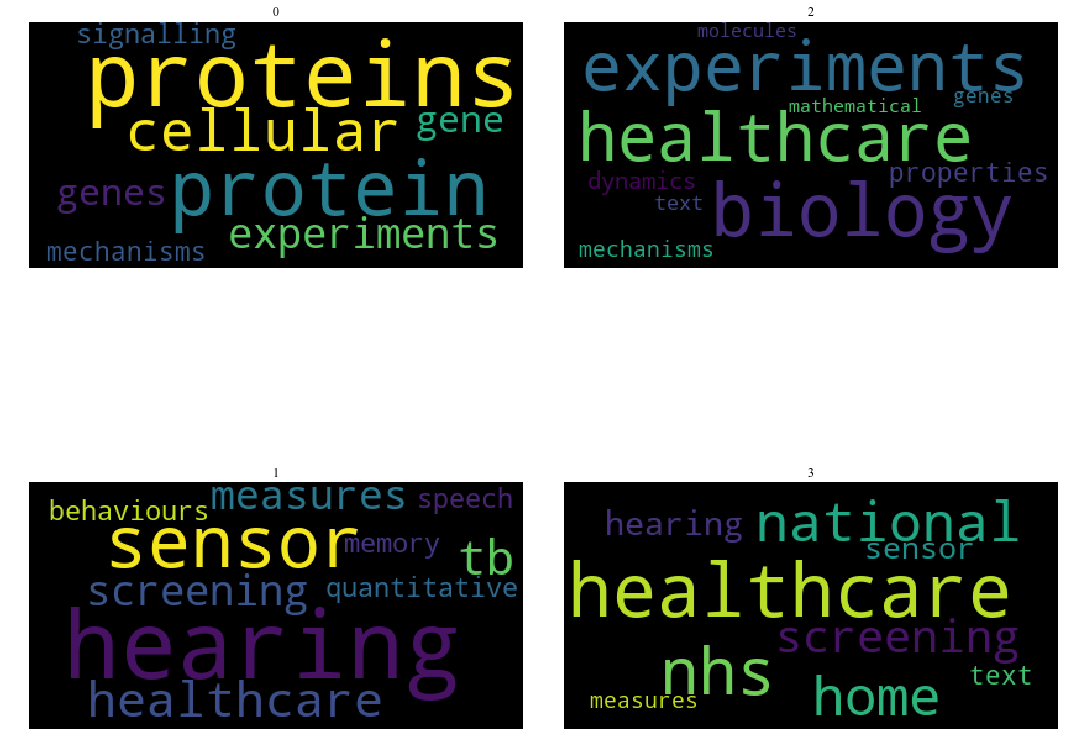

In [478]:
rows=2

fig,ax = plt.subplots(ncols=2,nrows=rows,figsize=(15,15))

for n,name in enumerate(traj_salient.summary.keys()):
    
    #print(n)
    
    if n<rows:
        make_wordcloud(traj_salient.summary[name],'tfidf',name,ax=ax[n][0])
        
    else:
        make_wordcloud(traj_salient.summary[name],'tfidf',name,ax=ax[n-rows][1])
        
plt.tight_layout()

In [86]:
cluster_name_lookup_2 = {n:name for n,name in enumerate(['cellular',
                                                       'social',
                                                       'brain_',
                                                       'Biomedical',
                                                       'Data',
                                                       'Heart',
                                                       'Sensors',
                                                       'Social'])}


mission_projects['cluster_name'] = [cluster_name_lookup[x] for x in mission_projects['cluster']]

In [87]:
sorted_clusters = mission_projects.cluster_name.value_counts().index

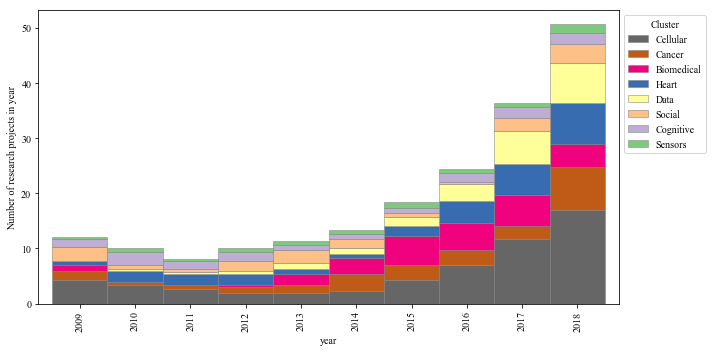

In [88]:
fig,ax = plt.subplots(figsize=(10,5))

pd.crosstab(mission_projects['year'],mission_projects['cluster_name']).loc[np.arange(2006,2019)].rolling(
    window=3).mean().loc[np.arange(2009,2019),sorted_clusters].plot.bar(
    stacked=True,ax=ax,width=1,cmap='Accent_r',linewidth=0.5,edgecolor='grey')

ax.legend(bbox_to_anchor=[1,1],title='Cluster')
ax.set_ylabel("Number of research projects in year")

plt.tight_layout()

#plt.savefig('../reports/figures/working_paper/fig_16_cluster_evol.pdf')
plt.savefig('/Users/jmateosgarcia/Desktop/2019/fig_4.eps', format='eps', dpi=1000)

In [89]:
funders_sorted = mission_projects['funder'].value_counts().index

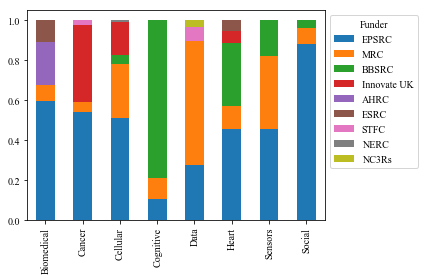

In [90]:
fig,ax = plt.subplots(figsize=(6,4))

pd.crosstab(mission_projects['cluster_name'],mission_projects['funder'],normalize=0).loc[:,funders_sorted].plot.bar(stacked=True,ax=ax)
ax.legend(bbox_to_anchor=[1,1],title='Funder')
ax.set_xlabel('')

plt.tight_layout()


plt.savefig('../reports/figures/working_paper/fig_17_cluster_funders.pdf')

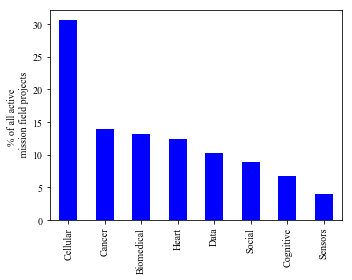

In [91]:
fig,ax = plt.subplots(figsize=(5,4))


(100*mission_projects.cluster_name.value_counts(normalize=1)).plot.bar(color='blue',ax=ax)

ax.set_ylabel('% of all active \n mission field projects')

plt.tight_layout()

plt.savefig('../reports/figures/working_paper/fig_18_cluster_distr.pdf')

In [92]:
#Ok, now I want to find the most similar documents a list of projects with 
#more than 1 occurrence of chronic related words and more than one occurrence of chronic occurring words
projects['has_ai_n'],projects['has_chronic_n'] = [querier(corpus_tokenised.tokenised,keys,
                                                     intersect=False) for keys in [.expanded_keywords[0],
                                                                                   mp.expanded_keywords[1]]]


SyntaxError: invalid syntax (<ipython-input-92-6b34d5605608>, line 4)

In [ ]:
high_indices = list(projects.reset_index(drop=True).loc[(projects.has_ai_n>1) & (projects.has_chronic_n>1)].index)

high_indices

In [ ]:
#This extracts those projects that are semantically closer to the initial list. 

close_docs = []

for ind in high_indices:
    sims = d2v.docvecs.most_similar([d2v.infer_vector(tagged_documents[ind].words)],topn=20)
    
    #Here we remove those projects that were already identified as high indices
    close_docs.append([s[0] for s in sims if (s[0] not in high_indices) & (s[1]>0.7)])


In [ ]:
sims = set(flatten_list(close_docs))

for t in projects.iloc[list(sims)]['title']:
    print(t)

Some of them look quite relevant. Others, not so much. I suppose the interdisciplinarity of the projects is pulling the vectors in multiple dimensions at the same time. Poor them!

### Ageing and inclusion/inequality (crude keyword search-based)

In [ ]:
age_expanded = synonym_chaser(seed_list=['ageing','aging'],model=w2v,similarity=0.8)
inclusion_expanded = synonym_chaser(seed_list=['inclusion','inclusiveness','inclusive','inequality'],model=w2v,similarity=0.8)

In [ ]:
projects['has_age'],projects['has_inclusion'] = [querier(corpus_tokenised.tokenised,keys) for keys in [age_expanded,inclusion_expanded]]

In [ ]:
pd.crosstab(projects['has_age']>0,projects['has_inclusion']>0)

In [ ]:
projects.loc[(projects['has_age']>0) & (projects['has_inclusion']>0)].head()

In [ ]:
projects.columns

In [ ]:
projects[['title','year','abstract','funder','amount','prods','ip','tech','spin','pubs','medical_sciences','mathematics_computing']]

In [ ]:
projects.shape

In [ ]:
org_metadata.sort_values('project_number',ascending=False)

In [ ]:
ai_projects = list(mprof.projects_labelled.loc[mprof.projects_labelled['ai']>0,'index'])
with open('/Users/jmateosgarcia/Desktop/gtr/gtr_ai_analysis/data/raw/ai_ids','w') as outfile:
    
    for item in ai_projects:
        outfile.write(f'{item}\n, ')
    
#    outfile.write(', '.join(ai_projects))

In [ ]:
mprof.projects_labelled.head()

In [ ]:
fig,ax = plt.subplots(figsize=(9,5))

mprof.mission_basics.plot.barh(color=['orange','blue','orange','blue'],ax=ax)

ax.set_yticklabels(['Chronic disease focus in AI projects','Chronic disease focus in all projects',
                    'AI use in chronic disease projects','AI use in all projects'])

ax.yaxis.set_tick_params(labelsize=14)


ax.set_xlabel('%',size=18)

ax.set_title('Overlap between AI and chronic diseases research',size=18)

plt.tight_layout()

In [ ]:
'raw' in os.listdir('../data/')

In [ ]:
import sklearn

In [ ]:
sklearn.__version__

In [519]:
re.sub('\n', '',mission_projects['abstract'].iloc[-1])

"The best way to diagnose malaria remains microscopic examination of blood smears, to identify the plasmodium parasites that are responsible. This takes around 30 minutes of microscopy, done by a trained technician - skilled workers who are in short supply. This project will create an intelligent microscope that can greatly multiply the skills of a technician by scanning over the smears automatically, and allowing them to review only the suspicious blood cells on a tablet computer after the smear has been scanned. Malaria is one of the world's most prevalent infectious diseases. It affects 200 million per year, and causes around 400 thousand deaths - most of them children in ODA countries in sub-Saharan Africa. Impressive progress is being made in reducing the incidence of malaria, which makes good diagnosis of the condition ever more important; it is increasingly inaccurate to assume that every patient with a fever has malaria, and doing so will waste drugs and leave potentially life 

In [1]:
74000*13/100

9620.0